# Gas-solid interface interaction
## Introduction
In this tutorial, we will learn about the principles of gas-solid interface interaction.

### Importing Relevant Functions
The inputs/outputs for GPUMD are processed using the [Atomic Simulation Environment (ASE)](https://wiki.fysik.dtu.dk/ase/) package.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ase.lattice.cubic import Diamond
from ase.io import write
from ase import Atoms

## Preparing the Inputs
The system we consider consists of argon and diamond, with dimensions of 3.57 nm × 3.57 nm × 7.14 nm (8000 carbon atoms, 100 argon atoms). The transport is in the $z$ direction. We divide the length in the $z$ direction into 2 groups. Group 0 (diamond) will be fixed. Group 1 (argon) will act as gas.
We use a [Lennard-Jones](https://gpumd.org/potentials/lennard_jones.html) potential.

### Generate the  [model.xyz](https://gpumd.org/gpumd/input_files/model_xyz.html) file:

In [4]:
C = Diamond('C', size=(10, 10, 10))
lx, ly, lz = C.cell.lengths()
C.cell = C.cell.new((lx, ly, 2*lz))
C

Lattice(symbols='C8000', pbc=True, cell=[35.699999999999996, 35.699999999999996, 71.39999999999999])

In [5]:
ar_atoms = 100
z_delta = 10
z_min, z_max = lz + z_delta, 2 * lz - z_delta
np.random.seed(42)
ar_positions = []
for _ in range(ar_atoms):
    x = np.random.uniform(0, lx)
    y = np.random.uniform(0, ly)
    z = np.random.uniform(z_min, z_max)
    ar_positions.append((x, y, z))
Ar = Atoms('Ar' * ar_atoms, positions=ar_positions)
Ar

Atoms(symbols='Ar100', pbc=False)

In [6]:
system = C + Ar
system.pbc = C.pbc
system

Lattice(symbols='C8000Ar100', pbc=True, cell=[35.699999999999996, 35.699999999999996, 71.39999999999999])

### Add Groups for Gas-solid

In [7]:
split = [0, lz, lz*2]
print("z-direction boundaries:", [float(round(x,2)) for x in split])

z-direction boundaries: [0.0, 35.7, 71.4]


In [8]:
group_label = []
for i, atom in enumerate(system):
    z_pos = atom.position[2]
    for j in range(len(split)-1):
        if z_pos >= split[j] and z_pos < split[j+1]:
            group_label.append(j)

In [9]:
system.arrays["group"] = np.array(group_label)

In [10]:
for i in range(len(split)-1):
    atom_num = len(system[system.arrays["group"] == i])
    print(f"group {i}: {atom_num} atoms")

group 0: 8000 atoms
group 1: 100 atoms


In [11]:
write("model.xyz", system)

### The `run.in file:
The [run.in input file](https://gpumd.org/gpumd/input_files/run_in.html) is given below:<br>
```
potential       lj_Ar_C.txt
velocity        300

minimize        sd -1 100

ensemble        nvt_lan 300.0 300.0 5000.0
fix             0
time_step       1
dump_position   1000
dump_thermo     1000
dump_force      1000
dump_velocity   1000 group 0 1
compute         0 1 1000 temperature
dump_restart    1000
run             30000
```

The first line uses the [potential](https://gpumd.org/gpumd/input_parameters/potential.html) keyword to define the potential to be used, which is specified in the file lj_Ar_C.txt.

The second line uses the [velocity](https://gpumd.org/gpumd/input_parameters/velocity.html) keyword and sets the velocities to be initialized with a temperature of 300 K.

The third line uses the [minimize](https://gpumd.org/gpumd/input_parameters/minimize.html) keyword to perform energy minimization via the steepest descent method. Regardless of the force_tolerance value, the minimization process will execute exactly 100 steps.

There is only one [run](https://gpumd.org/gpumd/input_parameters/run.html) in this simulation. 
  
  - An NVT [ensemble](https://gpumd.org/gpumd/input_parameters/ensemble.html) (Langevin thermostat) is applied with a target temperature of 300 K and a thermostat coupling constant of 5000 time steps.
  - Atoms in group 0 are fixed.
  - The integration [time_step](https://gpumd.org/gpumd/input_parameters/time_step.html) is set to 1 fs.
  - Atomic positions are output every 1000 steps.
  - Thermodynamic quantities are recorded every 1000 steps.
  - All atomic forces are output every 1000 steps.
  - Velocities of atoms in group 1 (grouping method 0) are output every 1000 steps.
  - Group temperatures are computed using the [compute](https://gpumd.org/gpumd/input_parameters/compute.html) command with grouping method 0. Data is sampled every 1 step and averaged over 1000 points before output.
  - Restart files are generated every 1000 steps.
  - The simulation runs for 30000 steps (30 ps).

## Results and Discussion
### Computation Time
- Using a GeForce GTX 1660 Ti GPU, the Gas-solid simulation takes about 13 minutes.

### Post-processing script
First, you should use Ovito to open the movie.xyz file, save a trajectory frame to the oneframe.xyz file, and then run this script to calculate the number density curve of argon (Ar).

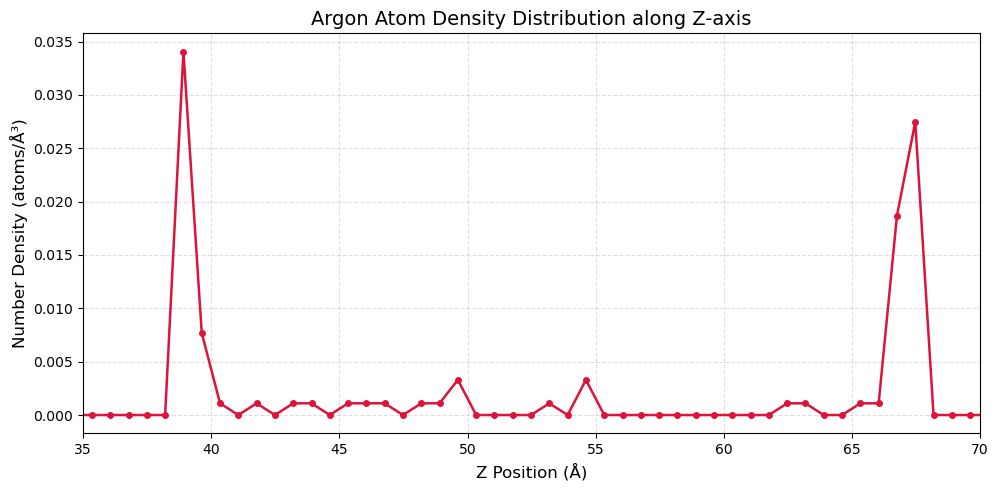

In [ ]:
def parse_lattice(line):
    lattice_str = line.split('"')[1]
    params = list(map(float, lattice_str.split()))
    return params[0], params[4], params[8]

def read_ar_positions(file_path):
    ar_z = []
    with open(file_path, 'r') as f:
        n_atoms = int(f.readline())
        lattice_line = f.readline()
        
        if 'Lattice="' in lattice_line:
            lx, ly, lz = parse_lattice(lattice_line)
        else:
            print("Warning:Fail to find Lattice")
            exit(1)
        
        for _ in range(n_atoms):
            line = f.readline()
            if not line.strip():
                continue
            parts = line.split()
            element = parts[1]
            if element == 'Ar':
                z = float(parts[4])
                ar_z.append(z)
    return ar_z, lx, ly, lz

def calculate_density(ar_z, lx, ly, lz, bins=100):
    if not ar_z:
        return None, None
    bin_width = lz / bins
    counts, edges = np.histogram(ar_z, bins=bins, range=(0, lz))
    volume_per_bin = lx * ly * bin_width  # Volume of each bin（Å³）
    density = counts / volume_per_bin  # Number density（atoms/Å³）
    z_center = (edges[:-1] + edges[1:]) / 2  # Midpoint of each bin interval
    return z_center, density

def plot_density(z_center, density):
    if z_center is None:
        print("Warning:Fail to find Atom")
        exit(1)
    plt.figure(figsize=(10, 5))
    plt.plot(z_center, density, '-o', color='crimson', linewidth=1.8, markersize=4)
    plt.xlabel('Z Position (Å)', fontsize=12)
    plt.ylabel('Number Density (atoms/Å³)', fontsize=12)
    plt.title('Argon Atom Density Distribution along Z-axis', fontsize=14)
    plt.grid(alpha=0.4, linestyle='--')
    plt.tight_layout()
    plt.xlim(35,70)
    plt.show()
    

if __name__ == "__main__":
    file_path = "/opt/GPUMD/examples/22/oneframe.xyz"
    try:
        ar_z, lx, ly, lz = read_ar_positions(file_path)
        z_center, density = calculate_density(ar_z, lx, ly, lz)
        plot_density(z_center, density)
    except Exception as e:
        print(f"Error: Data parsing failed. Reason: {str(e)}")
        print("Please check if the file format matches the example (especially the lattice line and atomic coordinate columns)")
    

The above figure is the number density distribution curve of Ar atoms. As the simulation progresses, Ar atoms are gradually adsorbed on the diamond interface, resulting in the number density on both sides being higher than that in the middle.